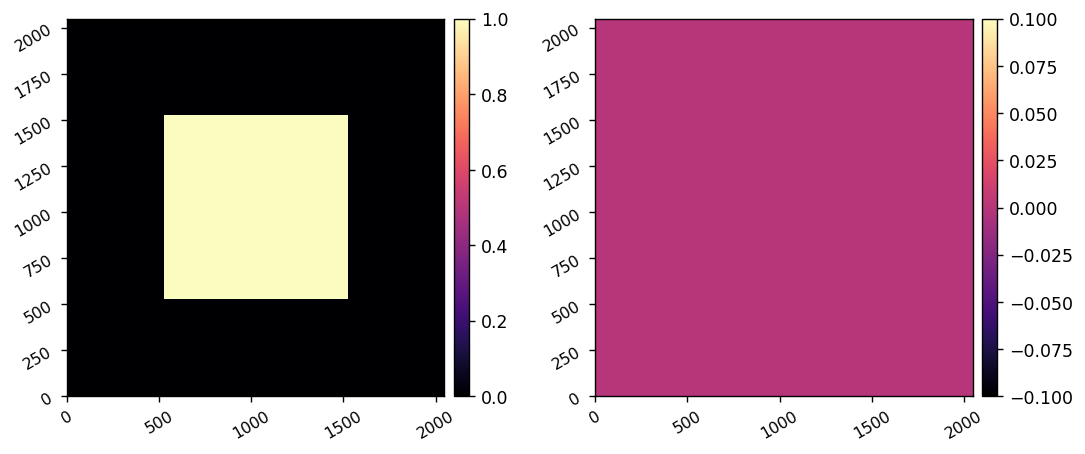

In [5]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import proper
import roman_phasec_proper as phasec

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import iefc_sim as iefc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

# dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_spc-wide_band4.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

dm1_best = proper.prop_fits_read( phasec.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm1.fits' )
dm2_best = proper.prop_fits_read( phasec.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm2.fits' )

reload(cgi)
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_opds=True, use_fieldstop=False, quiet=False)
misc.myimshow2(spci.inwave.intensity.get(), spci.inwave.phase.get())

npsf = spci.npsf
Nact = spci.Nact

In [6]:
!nvidia-smi

Wed May 25 11:29:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   36C    P0    37W / 250W |   1846MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Propagating wavelength 825.000 nm.
PSF calculated in 0.840s


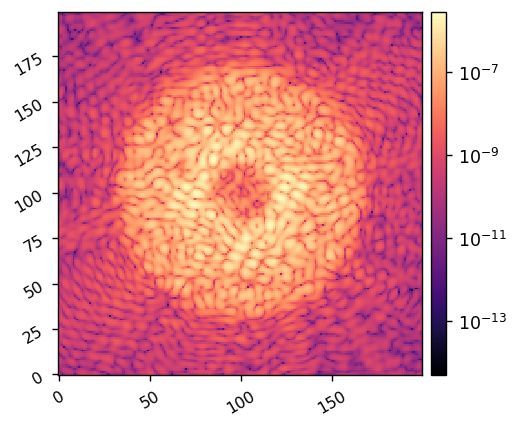

In [8]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=True, use_opds=True, quiet=False)

ref_psf = spci.calc_psf()[-1]

misc.myimshow(ref_psf.intensity, lognorm=True)

(_calc_psf pid=29517) Propagating wavelength 825.000 nm.
(_calc_psf pid=29517) PSF calculated in 0.858s
All PSFs calculated in 0.954s


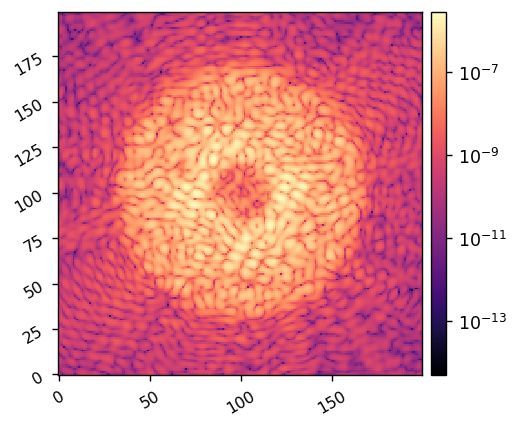

In [10]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=True, use_opds=True, quiet=False)

ref_psf = spci.calc_psfs()[0][-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

# Create dark hole ROI to calibrate and control

In [31]:
spci.psf_pixelscale_lamD

0.3030303030303029

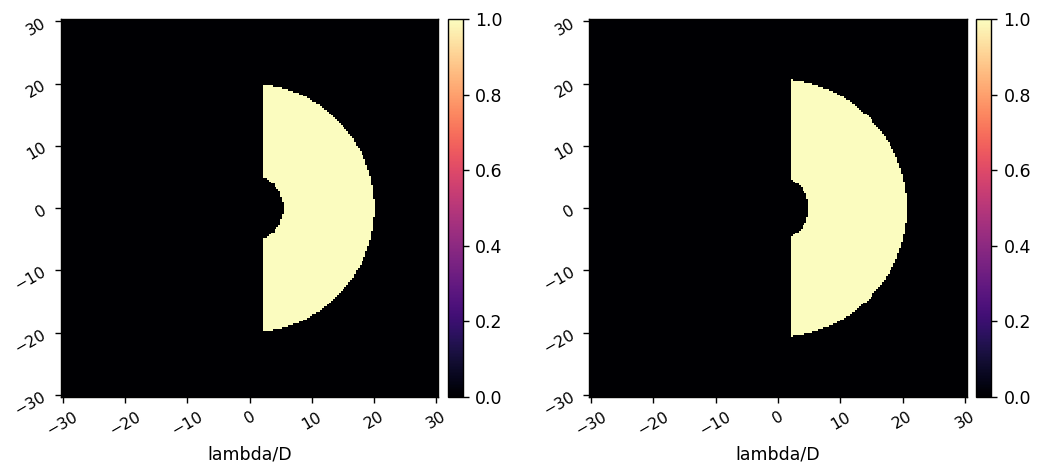

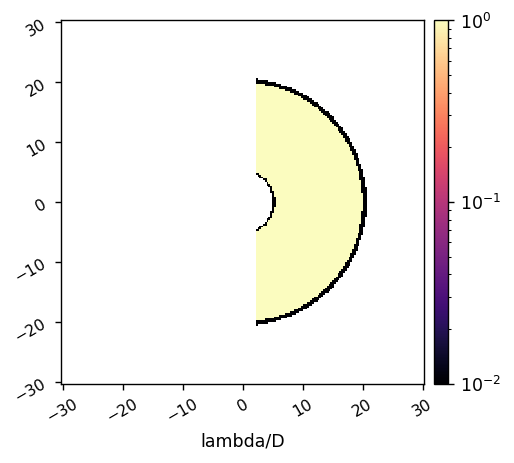

In [11]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=False, use_opds=False, quiet=False)

xfp = np.linspace(-0.5, 0.5, npsf) * npsf * spci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 5.4
owa = 20

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.4,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=spci.psf_pixelscale_lamD, pxscl2=spci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=spci.psf_pixelscale_lamD)


# Create probe and fourier modes

Creating Fourier modes:  (200, 200)
Calibration modes required: 1186


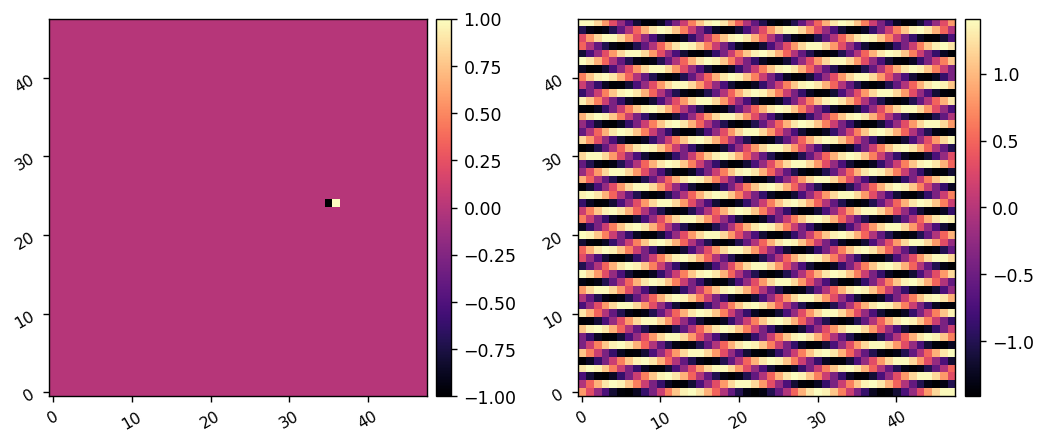

(True, True)

In [12]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=False, use_opds=False, quiet=False)

probe_modes = iefcu.create_probe_poke_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)
# probe_modes = iefcu.create_probe_jinc_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)
calibration_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)

calibration_amplitude = 0.006 * spci.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * spci.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_modes[0].reshape(Nact,Nact))

isinstance(probe_modes, np.ndarray), isinstance(calibration_modes, np.ndarray)

# Calibrate IEFC (or load in previous calibration data)

In [26]:
fname = 'spc_wide_dshaped_Yopds_polaxis{:d}_iwa{:.1f}_owa{:.1f}'.format(spci.polaxis, 
                                                           dh_params['inner_radius'], dh_params['outer_radius'])
print(fname)

spc_wide_dshaped_Yopds_polaxis0_iwa5.4_owa20.0


In [25]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=True, use_opds=True, quiet=True)

reload(iefc)
response_cube, calibration_cube = iefc.calibrate(spci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, DM=1, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 1186 in 4.596s
	Calibrated mode 2 / 1186 in 9.280s
	Calibrated mode 3 / 1186 in 14.019s
	Calibrated mode 4 / 1186 in 18.594s
	Calibrated mode 5 / 1186 in 23.208s
	Calibrated mode 6 / 1186 in 27.823s
	Calibrated mode 7 / 1186 in 32.407s
	Calibrated mode 8 / 1186 in 37.005s
	Calibrated mode 9 / 1186 in 41.644s
	Calibrated mode 10 / 1186 in 46.293s
	Calibrated mode 11 / 1186 in 50.912s
	Calibrated mode 12 / 1186 in 55.513s
	Calibrated mode 13 / 1186 in 60.125s
	Calibrated mode 14 / 1186 in 64.736s
	Calibrated mode 15 / 1186 in 69.353s
	Calibrated mode 16 / 1186 in 73.946s
	Calibrated mode 17 / 1186 in 78.578s
	Calibrated mode 18 / 1186 in 83.226s
	Calibrated mode 19 / 1186 in 87.865s
	Calibrated mode 20 / 1186 in 92.450s
	Calibrated mode 21 / 1186 in 97.029s
	Calibrated mode 22 / 1186 in 101.676s
	Calibrated mode 23 / 1186 in 106.301s
	Calibrated mode 24 / 1186 in 110.890s
	Calibrated mode 25 / 1186 in 115.503s
	Calibrated mode 26 / 1186 in 120.12

	Calibrated mode 209 / 1186 in 974.405s
	Calibrated mode 210 / 1186 in 979.041s
	Calibrated mode 211 / 1186 in 983.922s
	Calibrated mode 212 / 1186 in 988.609s
	Calibrated mode 213 / 1186 in 993.288s
	Calibrated mode 214 / 1186 in 997.987s
	Calibrated mode 215 / 1186 in 1002.616s
	Calibrated mode 216 / 1186 in 1007.260s
	Calibrated mode 217 / 1186 in 1011.992s
	Calibrated mode 218 / 1186 in 1016.650s
	Calibrated mode 219 / 1186 in 1021.312s
	Calibrated mode 220 / 1186 in 1025.924s
	Calibrated mode 221 / 1186 in 1030.569s
	Calibrated mode 222 / 1186 in 1035.214s
	Calibrated mode 223 / 1186 in 1039.900s
	Calibrated mode 224 / 1186 in 1044.534s
	Calibrated mode 225 / 1186 in 1049.234s
	Calibrated mode 226 / 1186 in 1053.862s
	Calibrated mode 227 / 1186 in 1058.489s
	Calibrated mode 228 / 1186 in 1063.110s
	Calibrated mode 229 / 1186 in 1067.739s
	Calibrated mode 230 / 1186 in 1072.426s
	Calibrated mode 231 / 1186 in 1077.054s
	Calibrated mode 232 / 1186 in 1081.686s
	Calibrated mode 233 /

	Calibrated mode 409 / 1186 in 1906.424s
	Calibrated mode 410 / 1186 in 1911.003s
	Calibrated mode 411 / 1186 in 1915.633s
	Calibrated mode 412 / 1186 in 1920.235s
	Calibrated mode 413 / 1186 in 1924.857s
	Calibrated mode 414 / 1186 in 1929.423s
	Calibrated mode 415 / 1186 in 1934.049s
	Calibrated mode 416 / 1186 in 1938.634s
	Calibrated mode 417 / 1186 in 1943.224s
	Calibrated mode 418 / 1186 in 1947.839s
	Calibrated mode 419 / 1186 in 1952.425s
	Calibrated mode 420 / 1186 in 1957.011s
	Calibrated mode 421 / 1186 in 1961.619s
	Calibrated mode 422 / 1186 in 1966.187s
	Calibrated mode 423 / 1186 in 1970.755s
	Calibrated mode 424 / 1186 in 1975.333s
	Calibrated mode 425 / 1186 in 1979.887s
	Calibrated mode 426 / 1186 in 1984.443s
	Calibrated mode 427 / 1186 in 1989.043s
	Calibrated mode 428 / 1186 in 1993.643s
	Calibrated mode 429 / 1186 in 1998.237s
	Calibrated mode 430 / 1186 in 2002.842s
	Calibrated mode 431 / 1186 in 2007.418s
	Calibrated mode 432 / 1186 in 2011.975s
	Calibrated mode

	Calibrated mode 609 / 1186 in 2819.192s
	Calibrated mode 610 / 1186 in 2823.733s
	Calibrated mode 611 / 1186 in 2828.305s
	Calibrated mode 612 / 1186 in 2832.828s
	Calibrated mode 613 / 1186 in 2837.413s
	Calibrated mode 614 / 1186 in 2841.967s
	Calibrated mode 615 / 1186 in 2846.461s
	Calibrated mode 616 / 1186 in 2850.969s
	Calibrated mode 617 / 1186 in 2855.488s
	Calibrated mode 618 / 1186 in 2859.996s
	Calibrated mode 619 / 1186 in 2864.517s
	Calibrated mode 620 / 1186 in 2869.022s
	Calibrated mode 621 / 1186 in 2873.541s
	Calibrated mode 622 / 1186 in 2878.121s
	Calibrated mode 623 / 1186 in 2882.628s
	Calibrated mode 624 / 1186 in 2887.160s
	Calibrated mode 625 / 1186 in 2891.698s
	Calibrated mode 626 / 1186 in 2896.218s
	Calibrated mode 627 / 1186 in 2900.711s
	Calibrated mode 628 / 1186 in 2905.233s
	Calibrated mode 629 / 1186 in 2909.740s
	Calibrated mode 630 / 1186 in 2914.297s
	Calibrated mode 631 / 1186 in 2918.789s
	Calibrated mode 632 / 1186 in 2923.319s
	Calibrated mode

	Calibrated mode 809 / 1186 in 3732.691s
	Calibrated mode 810 / 1186 in 3737.602s
	Calibrated mode 811 / 1186 in 3742.464s
	Calibrated mode 812 / 1186 in 3747.067s
	Calibrated mode 813 / 1186 in 3751.670s
	Calibrated mode 814 / 1186 in 3756.514s
	Calibrated mode 815 / 1186 in 3761.317s
	Calibrated mode 816 / 1186 in 3766.143s
	Calibrated mode 817 / 1186 in 3770.956s
	Calibrated mode 818 / 1186 in 3775.783s
	Calibrated mode 819 / 1186 in 3780.603s
	Calibrated mode 820 / 1186 in 3785.483s
	Calibrated mode 821 / 1186 in 3790.323s
	Calibrated mode 822 / 1186 in 3795.160s
	Calibrated mode 823 / 1186 in 3800.047s
	Calibrated mode 824 / 1186 in 3804.755s
	Calibrated mode 825 / 1186 in 3809.301s
	Calibrated mode 826 / 1186 in 3813.826s
	Calibrated mode 827 / 1186 in 3818.318s
	Calibrated mode 828 / 1186 in 3822.933s
	Calibrated mode 829 / 1186 in 3827.465s
	Calibrated mode 830 / 1186 in 3832.024s
	Calibrated mode 831 / 1186 in 3836.607s
	Calibrated mode 832 / 1186 in 3841.143s
	Calibrated mode

	Calibrated mode 1009 / 1186 in 4681.287s
	Calibrated mode 1010 / 1186 in 4686.182s
	Calibrated mode 1011 / 1186 in 4691.057s
	Calibrated mode 1012 / 1186 in 4695.932s
	Calibrated mode 1013 / 1186 in 4700.787s
	Calibrated mode 1014 / 1186 in 4705.686s
	Calibrated mode 1015 / 1186 in 4710.530s
	Calibrated mode 1016 / 1186 in 4715.408s
	Calibrated mode 1017 / 1186 in 4720.258s
	Calibrated mode 1018 / 1186 in 4725.164s
	Calibrated mode 1019 / 1186 in 4730.037s
	Calibrated mode 1020 / 1186 in 4734.863s
	Calibrated mode 1021 / 1186 in 4739.717s
	Calibrated mode 1022 / 1186 in 4744.624s
	Calibrated mode 1023 / 1186 in 4749.453s
	Calibrated mode 1024 / 1186 in 4754.325s
	Calibrated mode 1025 / 1186 in 4759.239s
	Calibrated mode 1026 / 1186 in 4764.078s
	Calibrated mode 1027 / 1186 in 4768.941s
	Calibrated mode 1028 / 1186 in 4773.734s
	Calibrated mode 1029 / 1186 in 4778.616s
	Calibrated mode 1030 / 1186 in 4783.549s
	Calibrated mode 1031 / 1186 in 4788.460s
	Calibrated mode 1032 / 1186 in 47

In [27]:
iefcu.save_pickle(data_dir/'response-data'/fname, response_cube)
iefcu.save_pickle(data_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/spc_wide_dshaped_Yopds_polaxis0_iwa5.4_owa20.0
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/spc_wide_dshaped_Yopds_polaxis0_iwa5.4_owa20.0


In [28]:
response_cube = iefcu.load_pickle(data_dir/'response-data'/fname)
calibration_cube = iefcu.load_pickle(data_dir/'calibration-data'/fname)

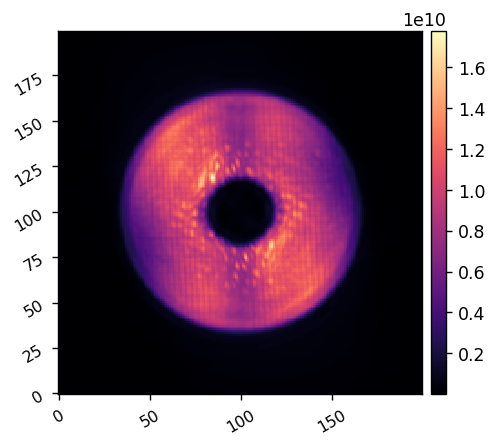

In [30]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(npsf,npsf).get())

# Create control matrix

In [31]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=True, use_opds=True, quiet=True)

# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, cp.array(weights.flatten()), rcond=1e-2, pca_modes=None)

Using Weighted Least Squares 


# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 15


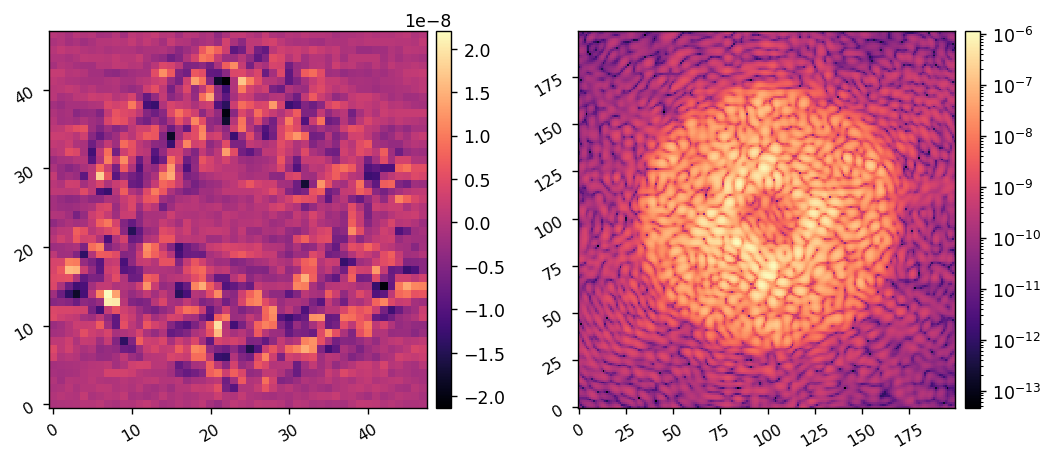

	Closed-loop iteration 2 / 15


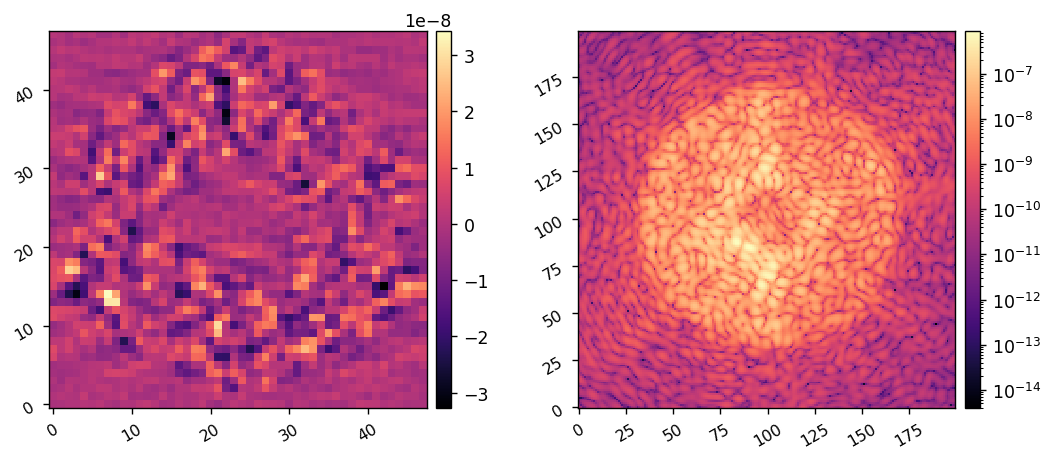

	Closed-loop iteration 3 / 15


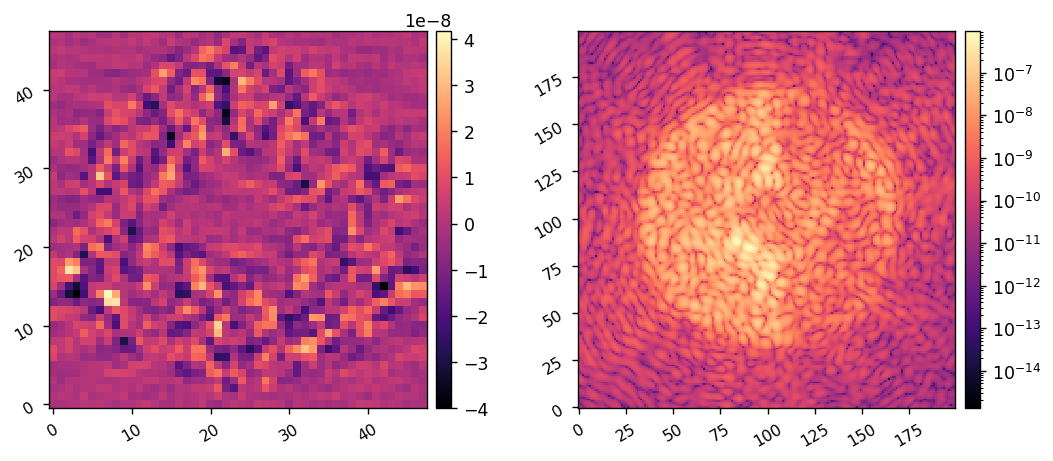

	Closed-loop iteration 4 / 15


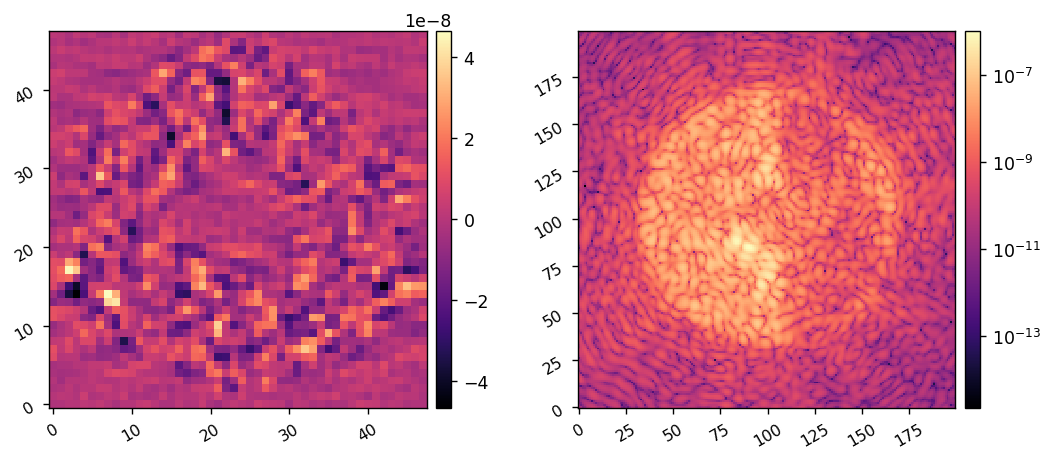

	Closed-loop iteration 5 / 15


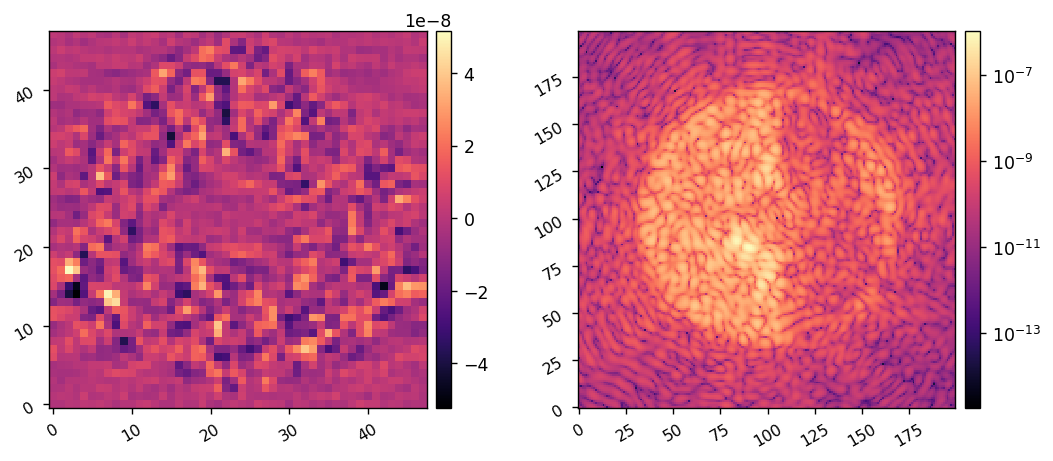

	Closed-loop iteration 6 / 15


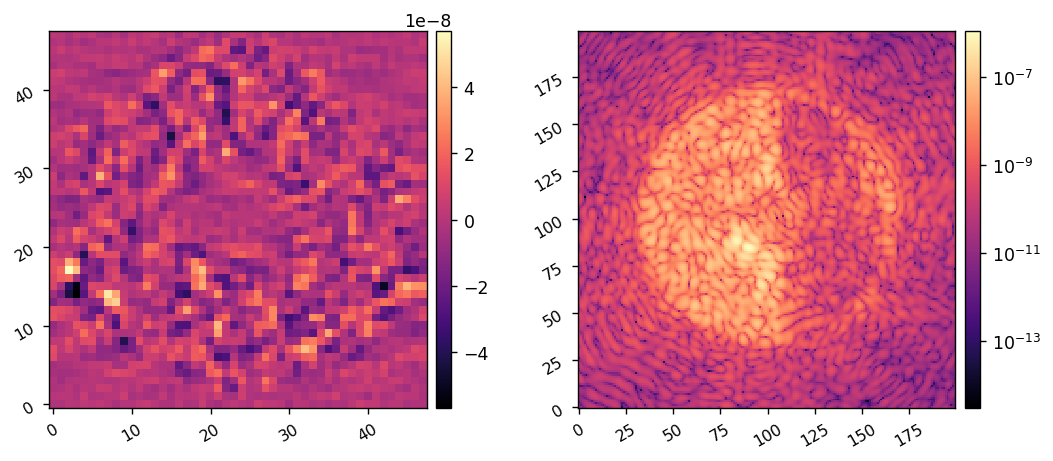

	Closed-loop iteration 7 / 15


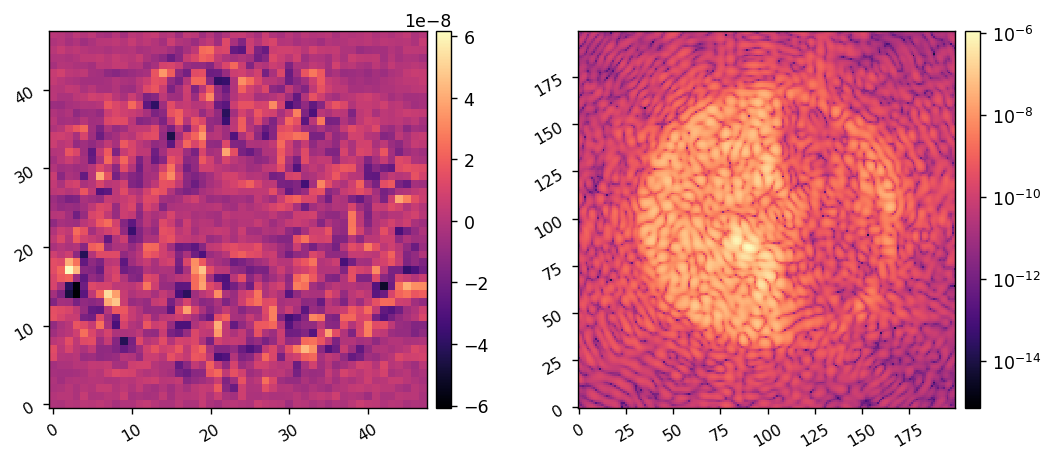

	Closed-loop iteration 8 / 15


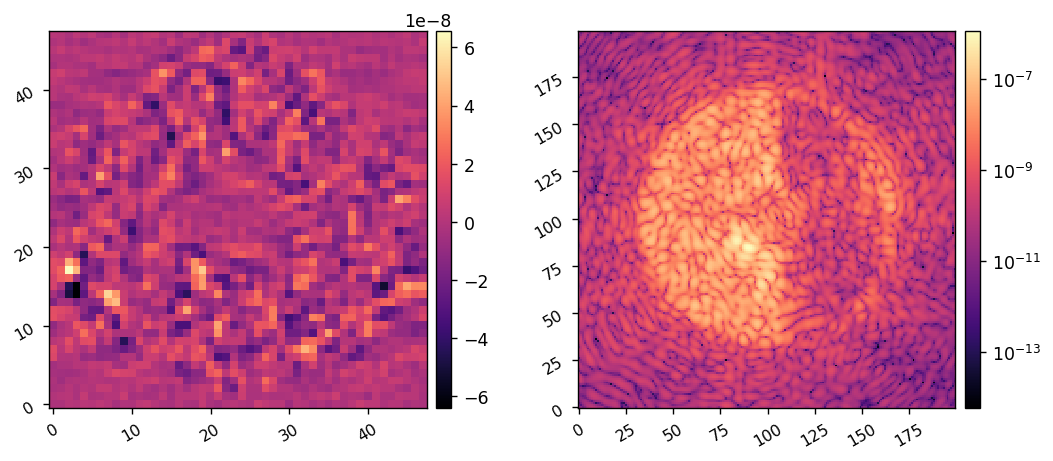

	Closed-loop iteration 9 / 15


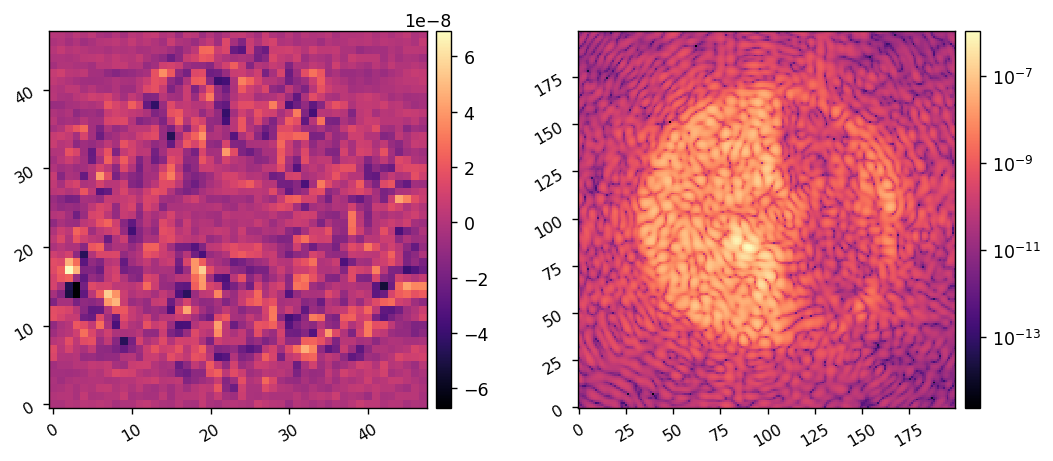

	Closed-loop iteration 10 / 15


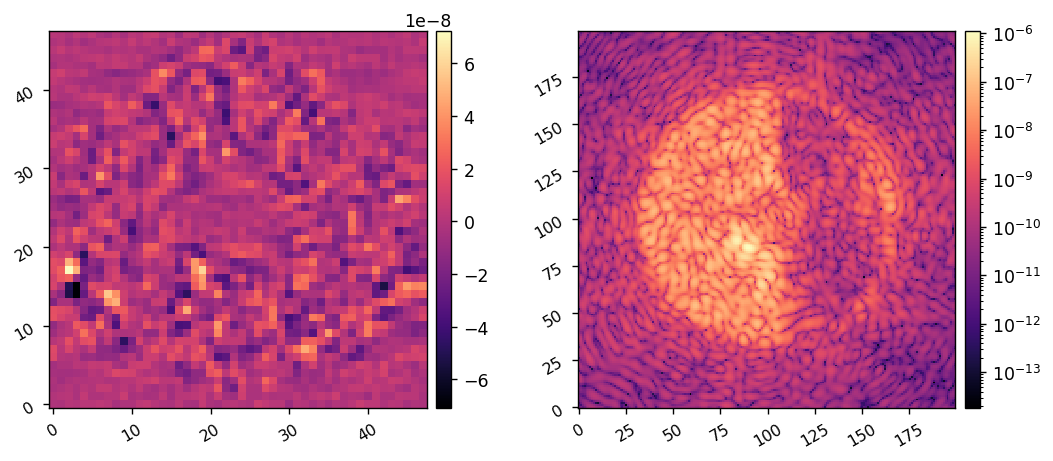

	Closed-loop iteration 11 / 15


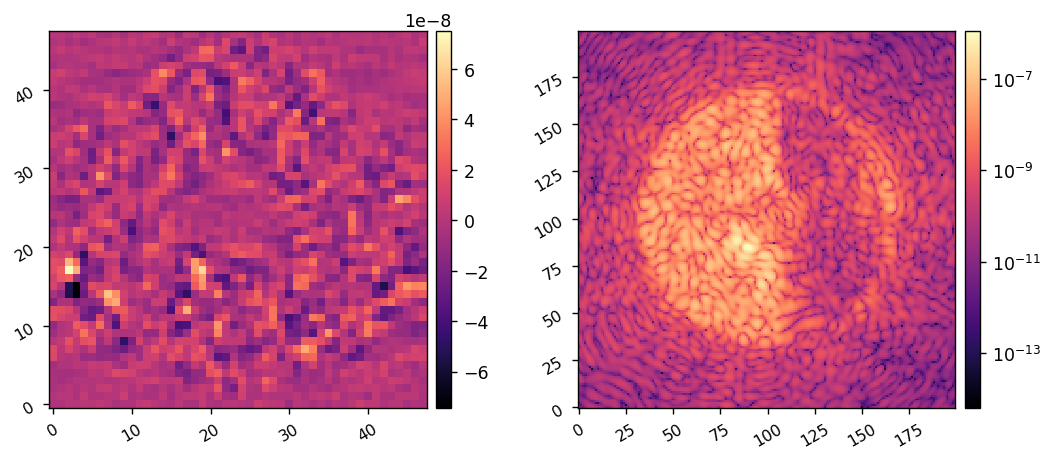

	Closed-loop iteration 12 / 15


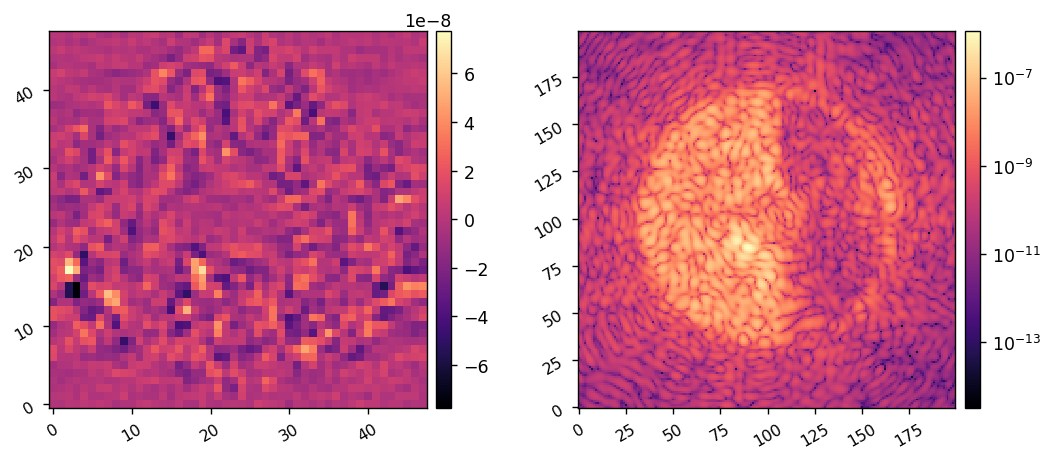

	Closed-loop iteration 13 / 15


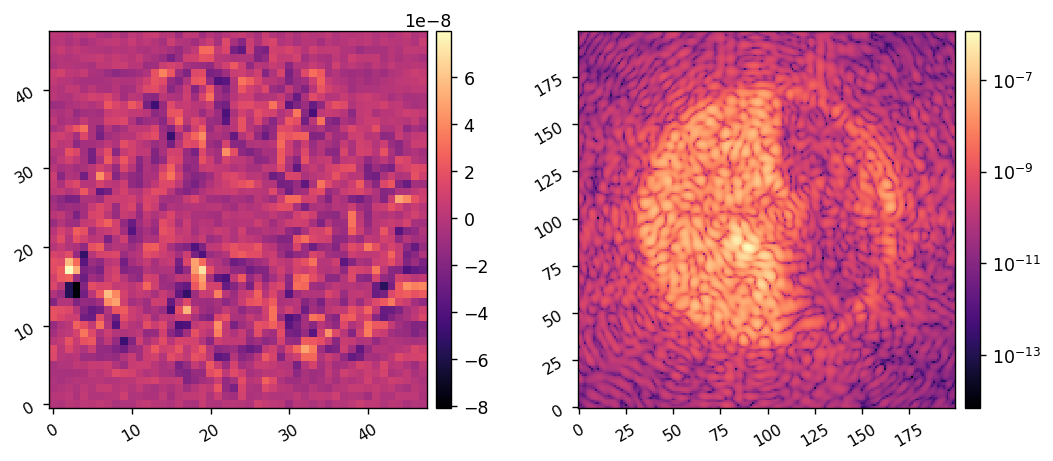

	Closed-loop iteration 14 / 15


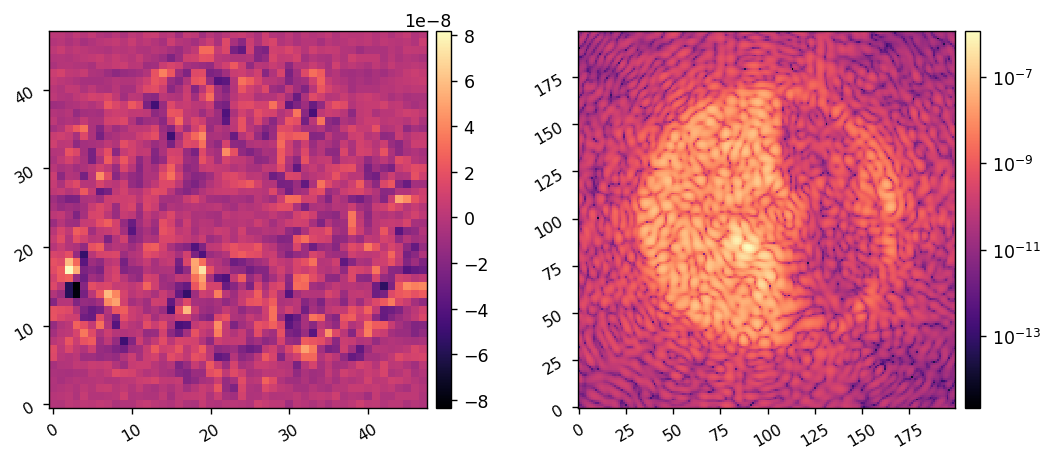

	Closed-loop iteration 15 / 15


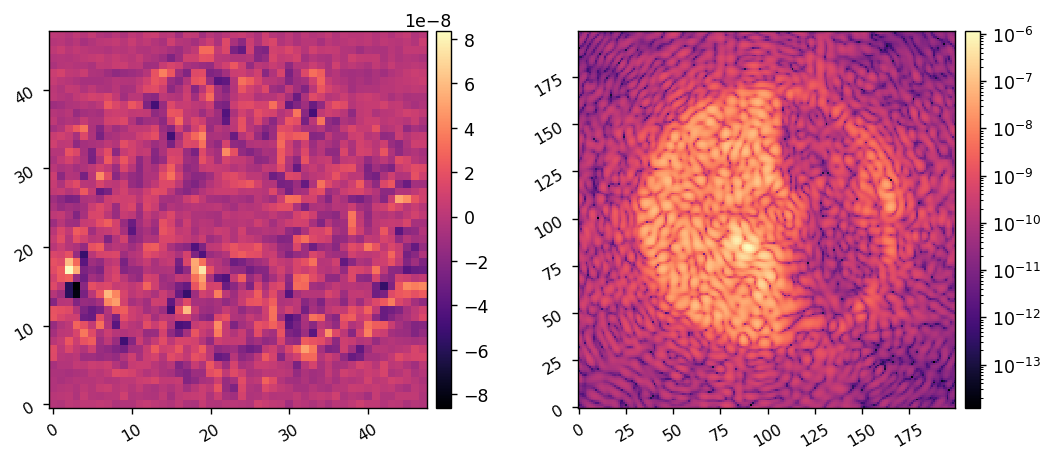

I-EFC loop completed in 62.547s.


In [35]:
spci = cgi.CGI_POPPY(cgi_mode='SPC825', polaxis=0, use_pupil_defocus=True, use_opds=True, quiet=True)

reload(iefc)
images, dm_commands = iefc.run(spci, control_matrix, probe_modes, probe_amplitude, 
                               calibration_modes, cp.array(weights), 
                               num_iterations=15, gain=-0.5, leakage=0.0,
                               display=True)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0


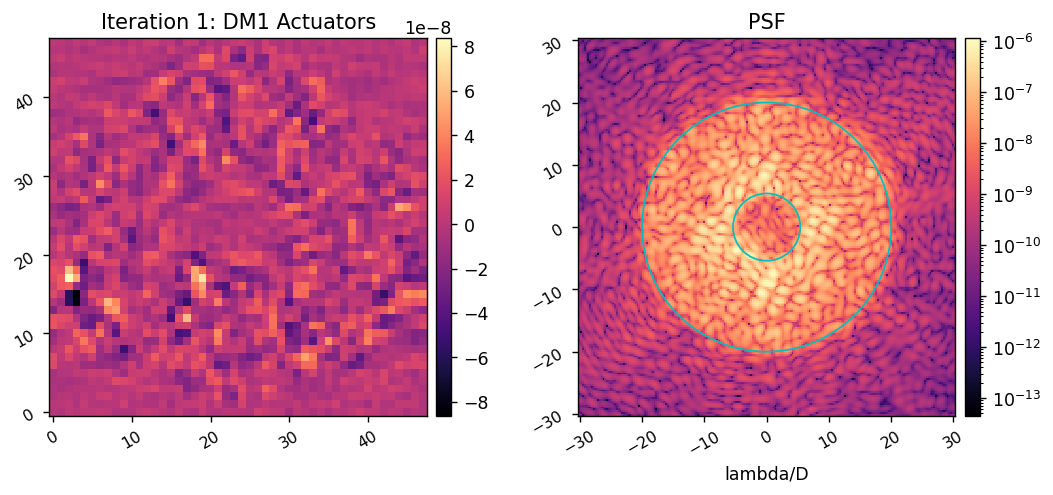

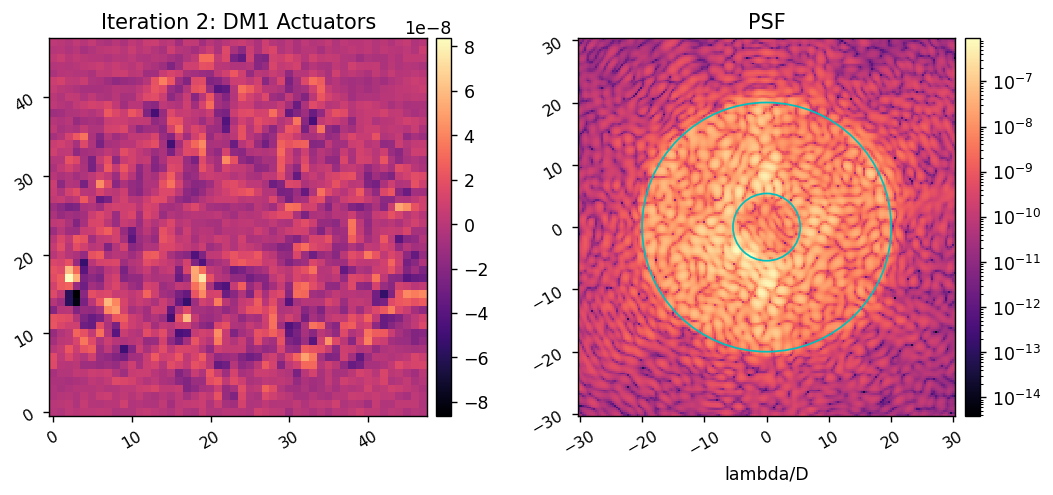

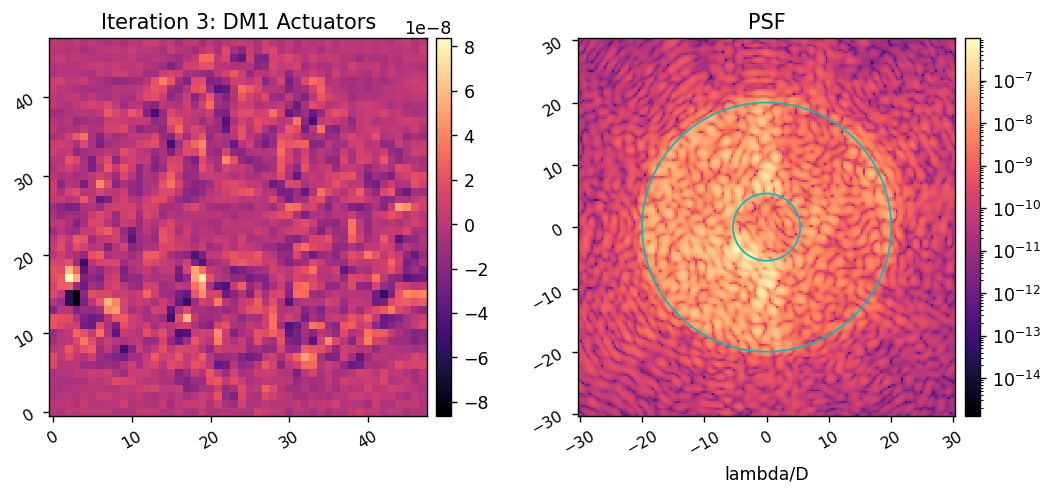

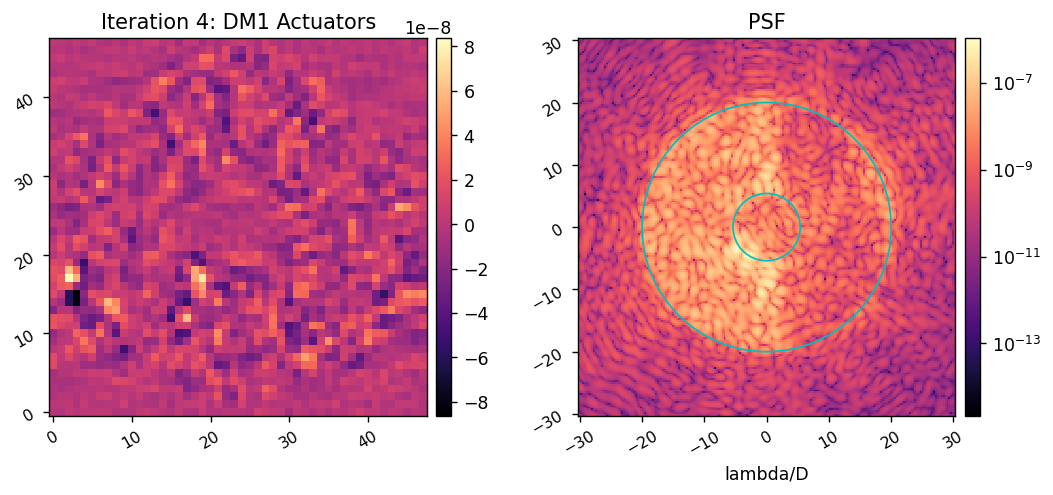

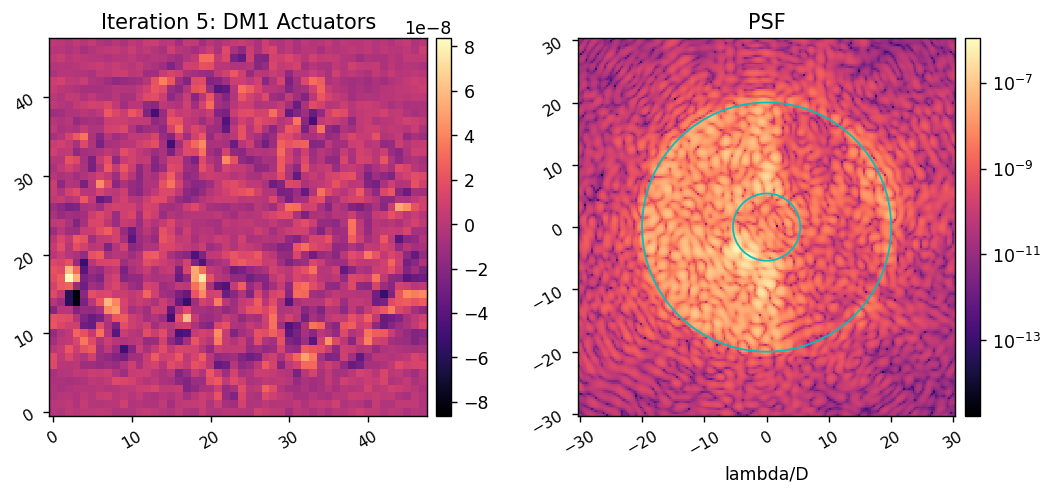

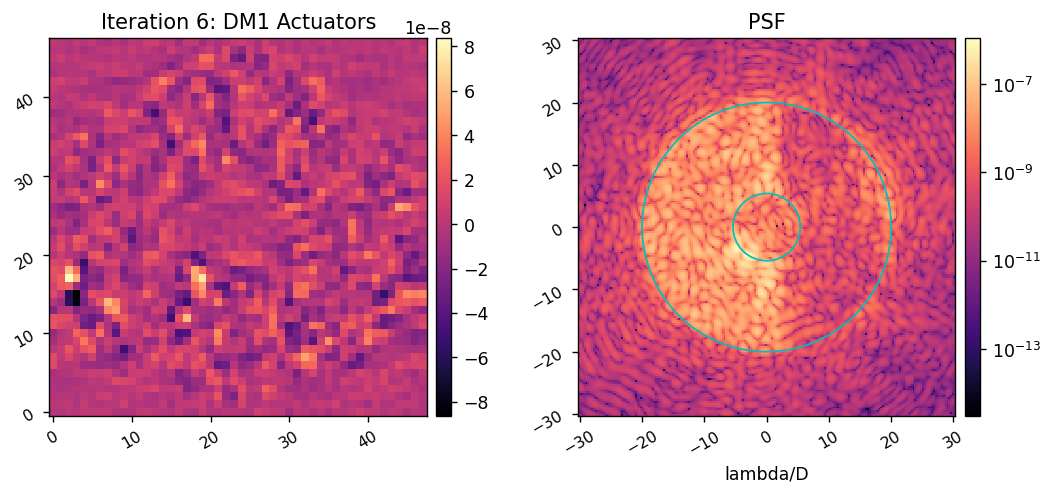

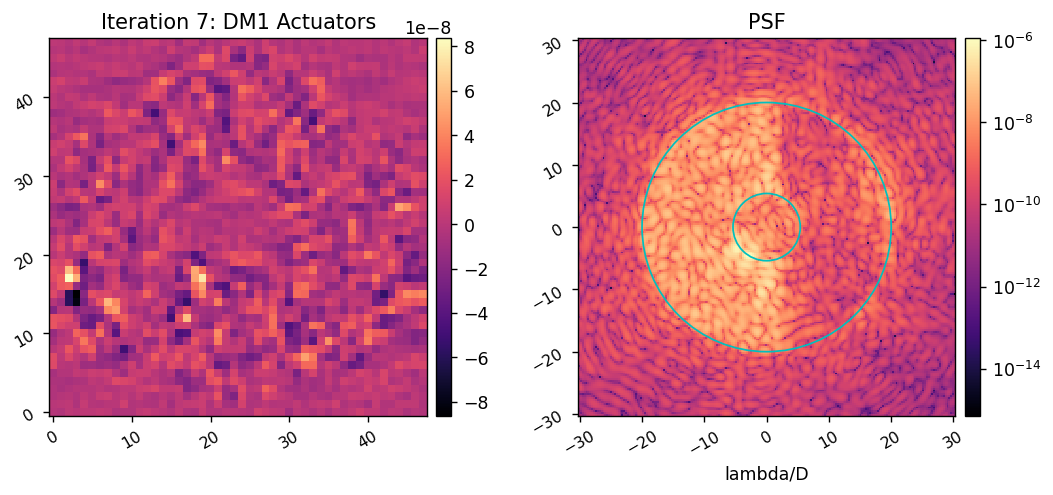

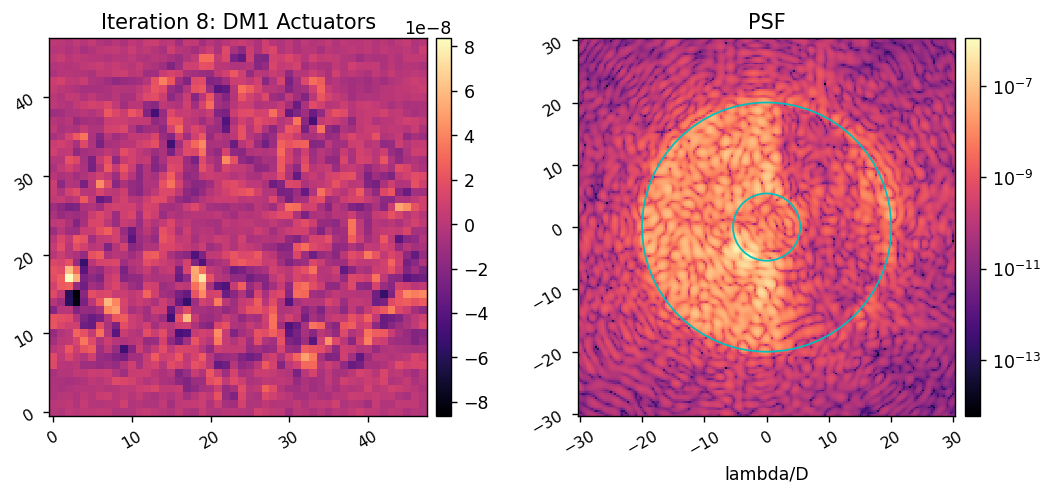

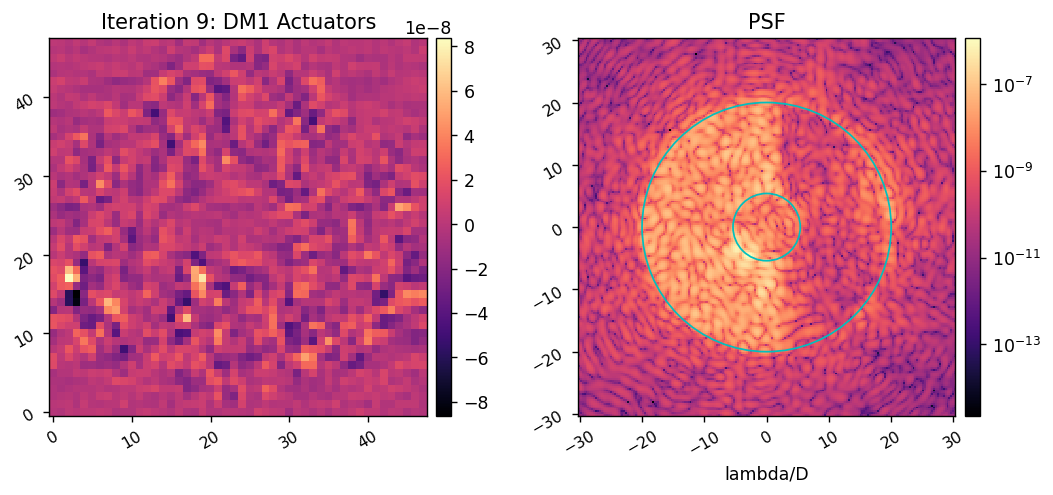

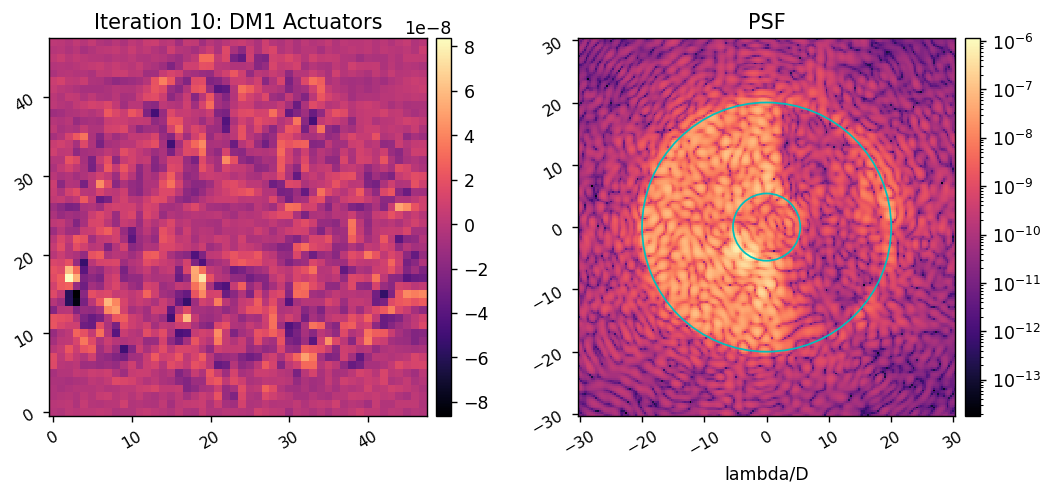

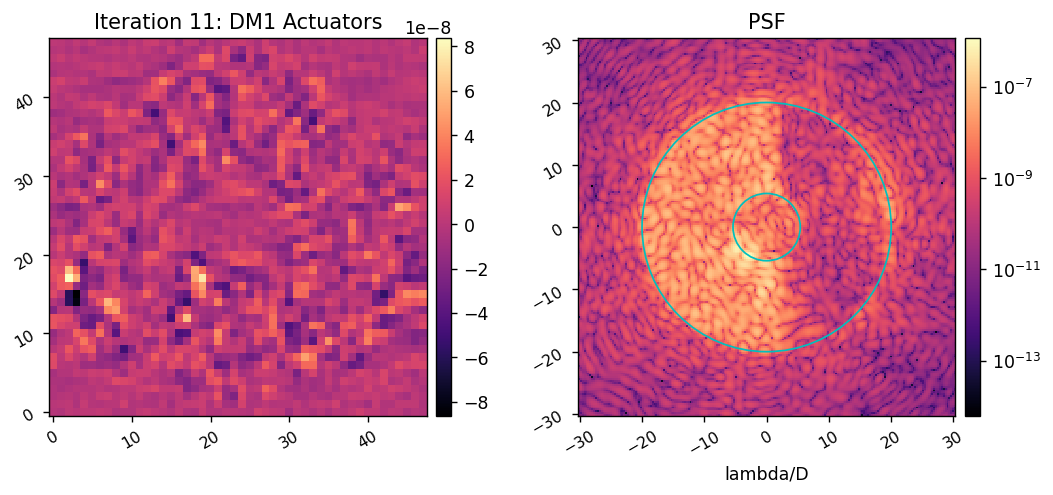

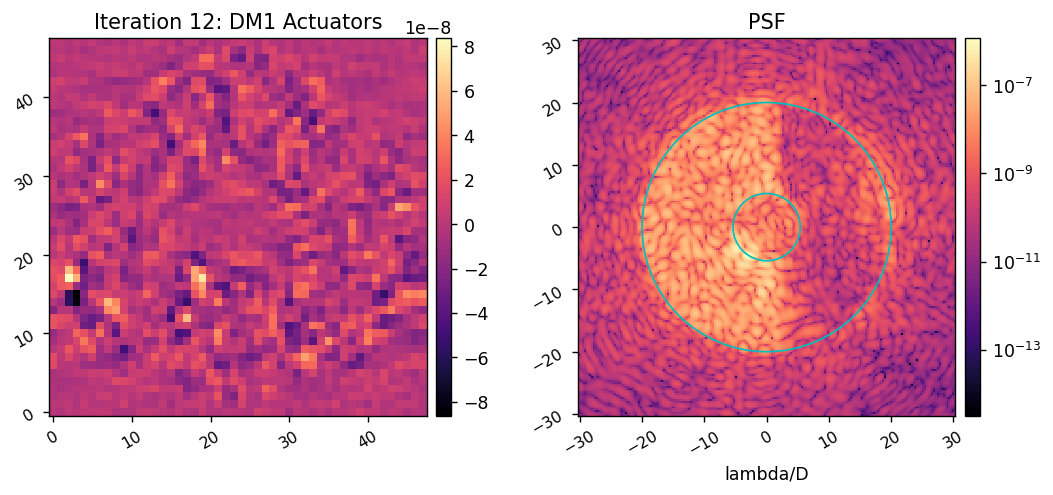

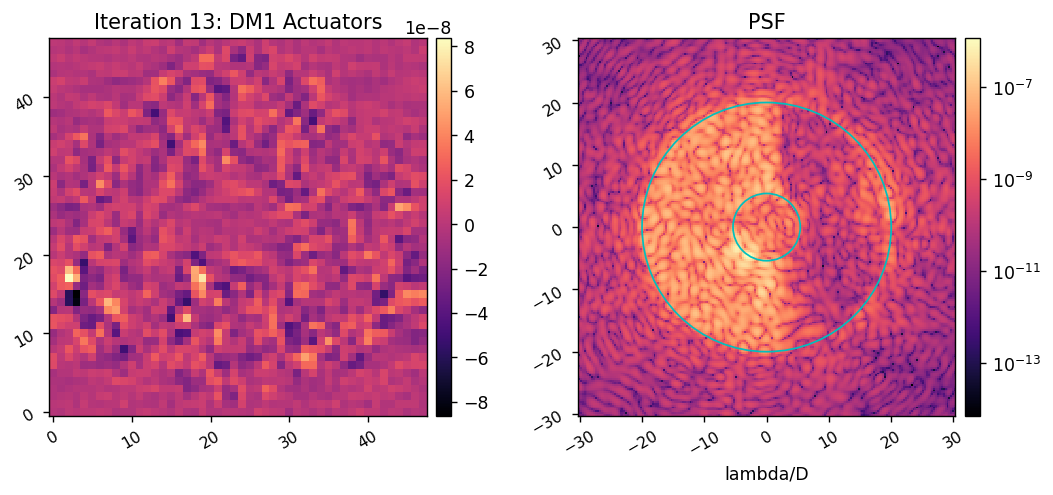

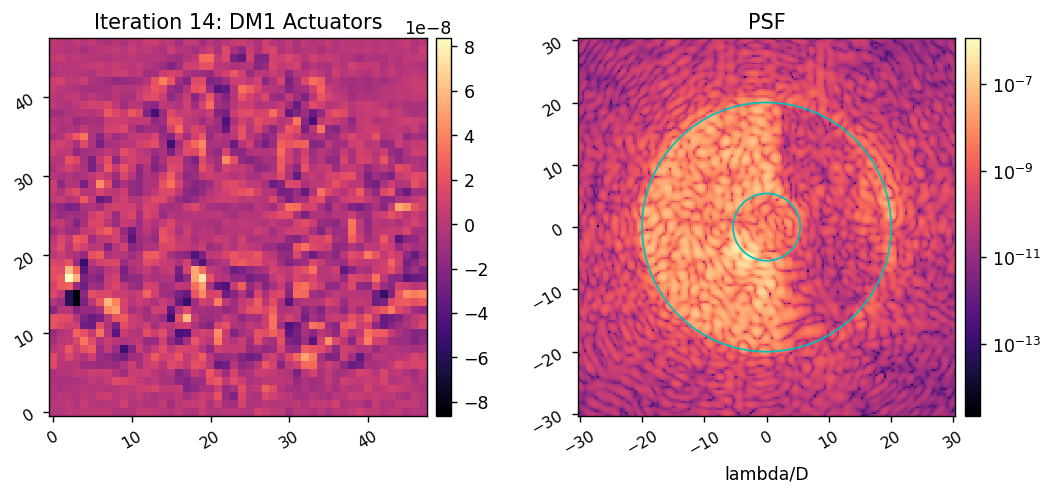

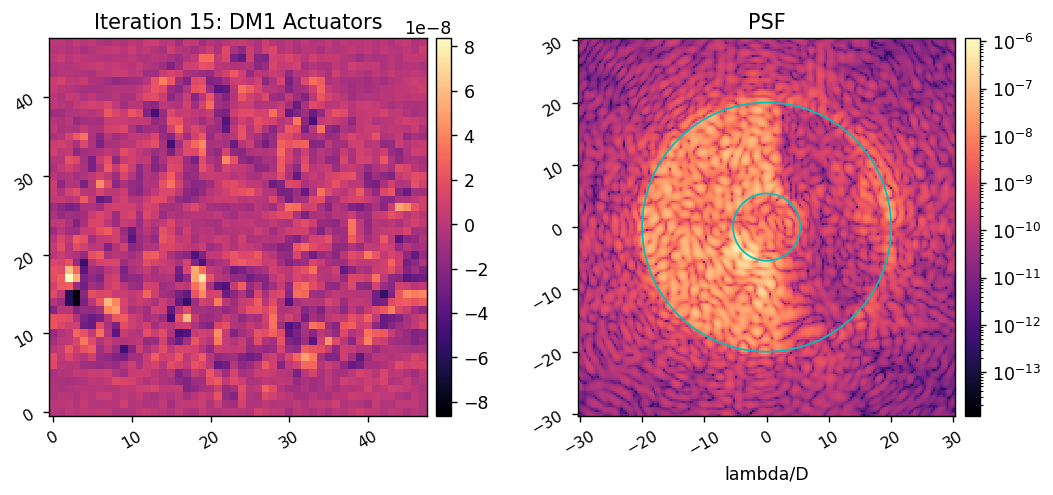

In [37]:
for i in range(len(images)):
    patches = iefcu.create_circ_patches(dh_params)
    misc.myimshow2(dm_commands[i], images[i].intensity.get(), 
                   'Iteration {:d}: DM1 Actuators'.format(i+1), 'PSF',
                   lognorm2=True, pxscl2=spci.psf_pixelscale_lamD, patches2=patches)